# **Experiment Notebook**



In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [2]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [3]:
# <Student to fill this section>
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Import custom package
!pip install my_krml_25552249==2025.0.7.1

  Using cached my_krml_25552249-2025.0.6.2-py3-none-any.whl.metadata (3.0 kB)
Using cached my_krml_25552249-2025.0.6.2-py3-none-any.whl (8.6 kB)
  Attempting uninstall: my_krml_25552249
    Found existing installation: my_krml_25552249 2025.0.7.0
    Uninstalling my_krml_25552249-2025.0.7.0:
      Successfully uninstalled my_krml_25552249-2025.0.7.0


---
## A. Project Description


In [5]:
# <Student to fill this section>
student_name = "Shawya Saito"
student_id = "25552240"

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

---
## B. Business Understanding

In [8]:
# <Student to fill this section>
business_use_case_description = """
Explain clearly what is the goal of this project for the business.
"""

In [9]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [10]:
# <Student to fill this section>
business_objectives = """
What will be the impact of accurate or incorrect results?
"""

In [11]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [12]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
How will the results be used?
Who will be the users of your predictions? Who will be impacted by your predictions?
"""

In [13]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [14]:
# Load training data
X_data = pd.read_csv('../../data/processed/X_data_clf.csv')
y_data = pd.read_csv('../../data/processed/y_data_clf.csv')

# Load test data
X_test = pd.read_csv('../../data/processed/X_test_clf.csv')
y_test = pd.read_csv('../../data/processed/y_test_clf.csv')

In [15]:
# # Make date datetime dtype
# X_data['date'] = pd.to_datetime(X_data['date'])

# # Filter for more than 2019
# mask = X_data['date'].dt.year >= 2010
# X_data = X_data[mask]
# y_data = y_data[mask]

## D. Feature Engineering and Feature Selection

In [16]:
# Combine data first to create features

# Combine features
X_combined = pd.concat([X_data, X_test], ignore_index=True)

# Combine target
y_combined = pd.concat([y_data, y_test], ignore_index=True)

# Combine all
df = pd.concat([X_combined, y_combined], axis=1)

### D.1 Create "is_rain_today" feature

In [17]:
df['is_rain_today'] = (df['precipitation_sum'] > 0).astype(int)

### D.2 Precipitation lag and rolling features

In [18]:
# Precipitation sum last week
df['precip_sum_lag7'] = df['precipitation_sum'].shift(7)

# Rolling sums (cumulative rain over last days)
df['precip_3day_sum'] = df['precipitation_sum'].rolling(3).sum().shift(1)
df['precip_7day_sum'] = df['precipitation_sum'].rolling(7).sum().shift(1)

# Rolling averages
df['precip_3day_mean'] = df['precipitation_sum'].rolling(3).mean().shift(1)
df['precip_7day_mean'] = df['precipitation_sum'].rolling(7).mean().shift(1)

### D.3 Humidity lag and rolling mean features

In [19]:
# Recent humidity trends
df['rh_mean_lag1'] = df['relative_humidity_2m_mean'].shift(1)
df['rh_3day_mean'] = df['relative_humidity_2m_mean'].rolling(3).mean().shift(1)
df['rh_7day_mean'] = df['relative_humidity_2m_mean'].rolling(7).mean().shift(1)

In [20]:
# Drop any row that has at least one NA
df = df.dropna(axis=0)

## Split data again

In [21]:
# split into train and test before exploring data
df_clean = df.copy()
df_clean['date'] = pd.to_datetime(df_clean['date'])

df_train = df_clean[df_clean["date"].dt.year != 2024]
df_test = df_clean[df_clean["date"].dt.year == 2024]

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit

# Features and target
X_data = df_train.drop(columns=['date', 'rain_in_7_days', 'weather_desc'])
y_data = df_train['rain_in_7_days']

X_test = df_test.drop(columns=['date', 'rain_in_7_days', 'weather_desc'])
y_test = df_test['rain_in_7_days']

### D.4 Feature Selection using Importance

In [23]:
import matplotlib.pyplot as plt

# Baseline XGBoost
model = XGBClassifier(eval_metric='logloss')
model.fit(X_data, y_data)

# Get feature importances
feat_imp_df = pd.DataFrame({
    'Feature': X_data.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

# from my_krml_25552249.features.selection import get_feature_importance
# feat_imp = get_feature_importance(X_data, y_data, model_type='xgb_classifier')

                         Feature  Importance
45                     month_cos    0.183469
49                   sunset_hour    0.030364
42                          year    0.026001
43                       quarter    0.019456
14             daylight_duration    0.018471
29         surface_pressure_mean    0.018407
22              dew_point_2m_min    0.017712
31          surface_pressure_min    0.017382
37  wet_bulb_temperature_2m_mean    0.017020
44                     month_sin    0.016753
48                  sunrise_hour    0.016721
30          surface_pressure_max    0.016612
20             dew_point_2m_mean    0.016559
6              precipitation_sum    0.016180
53               precip_7day_sum    0.015821
1             temperature_2m_max    0.015816
0            temperature_2m_mean    0.015574
13    et0_fao_evapotranspiration    0.015211
58                  rh_7day_mean    0.015174
15             sunshine_duration    0.014870
51               precip_sum_lag7    0.014475
12   wind_

### D.5 Feature Selection using SFS and RFE

In [24]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Define model for RFE
model_rfe = XGBClassifier(eval_metric='logloss')

# RFE
rfe = RFE(estimator=model_rfe, n_features_to_select=20) 
rfe.fit(X_data, y_data)

selected_features_rfe = X_data.columns[rfe.support_]
print("RFE selected features:", selected_features_rfe)



RFE selected features: Index(['temperature_2m_mean', 'apparent_temperature_max',
       'wind_direction_10m_dominant', 'daylight_duration', 'dew_point_2m_mean',
       'dew_point_2m_max', 'relative_humidity_2m_mean', 'surface_pressure_max',
       'surface_pressure_min', 'wind_gusts_10m_mean',
       'wet_bulb_temperature_2m_max', 'year', 'month_sin', 'month_cos',
       'sunrise_hour', 'sunset_hour', 'precip_3day_sum', 'precip_7day_sum',
       'rh_mean_lag1', 'rh_7day_mean'],
      dtype='object')


In [25]:
# Keep top 30 features for SFS
top_features = feat_imp_df['Feature'].head(30).tolist()
X_data_top = X_data[top_features]

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

tscv = TimeSeriesSplit(n_splits=5)
model_sfs = XGBClassifier(eval_metric='logloss')

sfs = SequentialFeatureSelector(
    model_sfs,
    n_features_to_select=20, 
    direction='forward',
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1
)

sfs.fit(X_data_top, y_data)

selected_features_sfs = X_data_top.columns[sfs.get_support()]
print("SFS selected features:", selected_features_sfs)

SFS selected features: Index(['month_cos', 'sunset_hour', 'quarter', 'daylight_duration',
       'surface_pressure_mean', 'wet_bulb_temperature_2m_mean', 'month_sin',
       'sunrise_hour', 'surface_pressure_max', 'precipitation_sum',
       'precip_7day_sum', 'temperature_2m_max', 'rh_7day_mean',
       'precip_sum_lag7', 'dew_point_2m_max', 'rh_3day_mean',
       'apparent_temperature_max', 'pressure_msl_min',
       'wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_min'],
      dtype='object')


In [28]:
rfe_features = set([
    'temperature_2m_mean', 'apparent_temperature_max',
    'wind_direction_10m_dominant', 'daylight_duration', 'dew_point_2m_mean',
    'dew_point_2m_max', 'relative_humidity_2m_mean', 'surface_pressure_max',
    'surface_pressure_min', 'wind_gusts_10m_mean',
    'wet_bulb_temperature_2m_max', 'year', 'month_sin', 'month_cos',
    'sunrise_hour', 'sunset_hour', 'precip_3day_sum', 'precip_7day_sum',
    'rh_mean_lag1', 'rh_7day_mean'
])

sfs_features = set([
    'month_cos', 'sunset_hour', 'quarter', 'daylight_duration',
    'surface_pressure_mean', 'wet_bulb_temperature_2m_mean', 'month_sin',
    'sunrise_hour', 'surface_pressure_max', 'precipitation_sum',
    'precip_7day_sum', 'temperature_2m_max', 'rh_7day_mean',
    'precip_sum_lag7', 'dew_point_2m_max', 'rh_3day_mean',
    'apparent_temperature_max', 'pressure_msl_min',
    'wet_bulb_temperature_2m_max', 'wet_bulb_temperature_2m_min'
])

common_features = rfe_features.intersection(sfs_features)
print("Common features:", common_features)
print(len(common_features))

Common features: {'sunrise_hour', 'precip_7day_sum', 'rh_7day_mean', 'daylight_duration', 'month_cos', 'month_sin', 'surface_pressure_max', 'wet_bulb_temperature_2m_max', 'dew_point_2m_max', 'apparent_temperature_max', 'sunset_hour'}
11


## D.z Final Selection of Features

In [29]:
# 
features_list = [
    'apparent_temperature_max',
    'dew_point_2m_max',
    'surface_pressure_max',
    'precip_7day_sum',
    'daylight_duration',
    'month_sin',
    'month_cos',
    'sunrise_hour',
    'sunset_hour',
    'wet_bulb_temperature_2m_max',
    'rh_7day_mean',
    'temperature_2m_mean',
    'dew_point_2m_mean',
    'precip_3day_sum',
    'rh_mean_lag1',
    'wind_direction_10m_dominant',
    'quarter',
    'temperature_2m_max',
    'surface_pressure_mean',
    'wet_bulb_temperature_2m_min'
]

target = 'rain_in_7_days'

In [30]:
# <Student to fill this section>
feature_selection_explanations = """
These features were chosen because they consistently ranked higher across RFE (model-driven selection), Random Forest importance (predictive power), and mutual information (non-linear dependence).
In contrast, features like precipitation lags and time components showed weak and inconsistent contribution across methods, so they were excluded."""

In [31]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [32]:
# <Student to fill this section>

In [33]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Provide some explanations on why you believe it is important to fix this issue and its impacts
"""

In [34]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [35]:
# <Student to fill this section>

In [36]:
# <Student to fill this section>
feature_engineering_1_explanations = """
Provide some explanations on why you believe it is important to create this feature and its impacts
"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

Here, we will save X_data, y_data, X_test and y_test with all potential variables for future experiments.

In [38]:
# Select the relevant features
X_data = X_data[features_list]
X_test = X_test[features_list]

In [39]:
# <Student to fill this section>
data_splitting_explanations = """
Provide some explanations on what is the best strategy to use for data splitting for this dataset
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

---
## H. Save Datasets

> Do not change this code

In [41]:
# # Do not modify this code
# # Save training set
# try:
#   X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
#   y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

#   X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
#   y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

#   X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
#   y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
# except Exception as e:
#   print(e)

In [42]:
# # Do not modify this code
# # Save training set
# try:
#   X_data.to_csv('../../data/processed/X_data_clf.csv', index=False)
#   y_data.to_csv('../../data/processed/y_data_clf.csv', index=False)

#   X_test.to_csv('../../data/processed/X_test_clf.csv', index=False)
#   y_test.to_csv('../../data/processed/y_test_clf.csv', index=False)
# except Exception as e:
#   print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [43]:
# <Student to fill this section>

In [44]:
# <Student to fill this section>
performance_metrics_explanations = """
Provide some explanations on why you believe the performance metrics you chose is appropriate
"""

In [45]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [46]:
# <Student to fill this section>

In [47]:
# <Student to fill this section>
algorithm_selection_explanations = """
Provide some explanations on why you believe this algorithm is a good fit
"""

In [48]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [49]:
# <Student to fill this section>

In [50]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from xgboost import XGBClassifier


tscv = TimeSeriesSplit(n_splits=5)

In [51]:
space = {
    'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 400, 25, dtype=int)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, dtype=int)),
}


In [52]:
def objective(params):
    aucs = []
    f1s = []
    for train_idx, val_idx in tscv.split(X_data):
        X_train, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_train, y_val = y_data.iloc[train_idx], y_data.iloc[val_idx]
        
        model = XGBClassifier(
            **params,
            eval_metric="logloss",
            random_state=33,
            early_stopping_rounds=20,
            class_weight='balanced'
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        preds = model.predict(X_val)
        preds_proba = model.predict_proba(X_val)[:, 1]

        f1_fold = f1_score(y_val, preds)
        auc_fold = roc_auc_score(y_val, preds_proba)

        f1s.append(f1_fold)
        aucs.append(auc_fold)

    return {
        'loss': -np.mean(aucs),  # maximise ROC-AUC
        'status': STATUS_OK,
        'fold_aucs': aucs,
        'fold_f1s': f1s,
        'mean_auc': np.mean(aucs),
        'mean_f1': np.mean(f1s)
    }

# Run Hyperopt
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(33)
)

100%|████████| 50/50 [00:13<00:00,  3.60trial/s, best loss: -0.6237109071238451]


In [53]:
print("Best parameters:", best)

Best parameters: {'colsample_bytree': np.float64(0.6943917650145702), 'gamma': np.float64(1.5746487382334453), 'learning_rate': np.float64(0.16639219844870703), 'max_depth': np.int64(0), 'min_child_weight': np.int64(0), 'n_estimators': np.int64(0), 'subsample': np.float64(0.8052355343267308)}


In [54]:
# Best trial index
best_trial_idx = np.argmin([t['result']['loss'] for t in trials.trials])
best_trial = trials.trials[best_trial_idx]['result']

print("Fold-wise ROC-AUC:", best_trial['fold_aucs'])
print("Mean ROC-AUC:", best_trial['mean_auc'])
print("Fold-wise F1:", best_trial['fold_f1s'])
print("Mean F1:", best_trial['mean_f1'])

Fold-wise ROC-AUC: [np.float64(0.6016530348687043), np.float64(0.6248857302118171), np.float64(0.6169424307513314), np.float64(0.6061622073578596), np.float64(0.6689111324295134)]
Mean ROC-AUC: 0.6237109071238451
Fold-wise F1: [np.float64(0.5142857142857142), np.float64(0.5102880658436214), np.float64(0.5551601423487544), np.float64(0.5498108448928121), np.float64(0.6624869383490073)]
Mean F1: 0.5584063411439819


In [55]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
Explain why you are tuning these hyperparameters
"""

In [56]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [57]:
# Best parameters
best_params = {
    'max_depth': [2,3,4,5,6,7,8,9][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': [i for i in range(50,400,25)][best['n_estimators']],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'min_child_weight': [i for i in range(1,10)][best['min_child_weight']],
}

final_model = XGBClassifier(
    **best_params,
    eval_metric="logloss",
    random_state=33,
    class_weight='balanced'
)

final_model.fit(X_data, y_data)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None,
              colsample_bytree=np.float64(0.6943917650145702), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(1.5746487382334453), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.16639219844870703), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None, ...)

In [59]:
# Save final model
import joblib
from joblib import dump

try:
    dump(final_model, '../../models/rain_or_not/xgb_model_clf.joblib')
except Exception as e:
    print(e)


### J.4 Model Technical Performance

> Provide some explanations on model performance


In [60]:
y_pred = final_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_pred))

Test Accuracy: 0.5810055865921788
Test F1: 0.6462264150943396
Test ROC-AUC: 0.5690788387224626


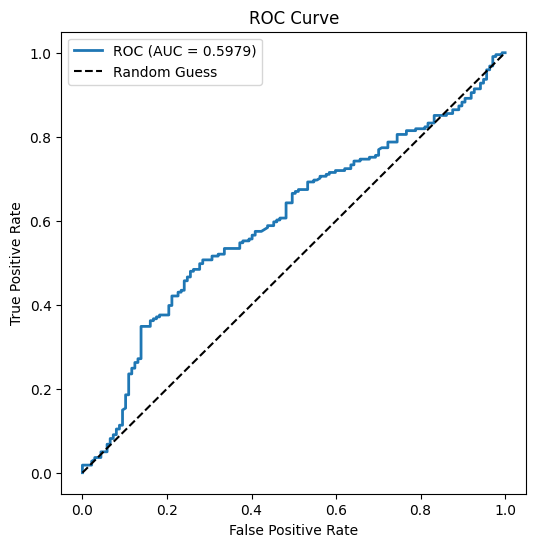

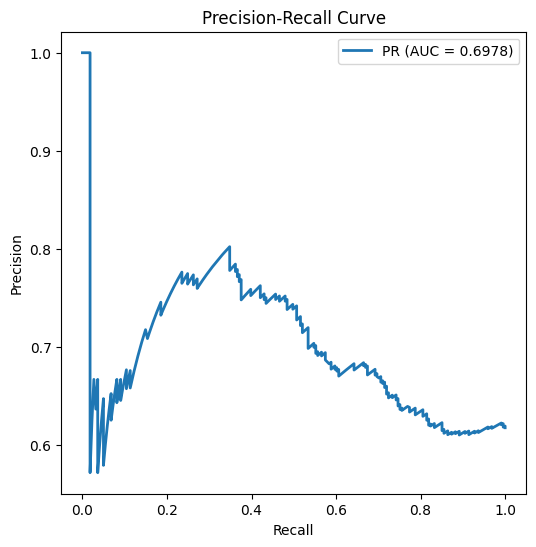

In [61]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc, plot_pr
# Get predicted probabilities for the positive class
y_probs = final_model.predict_proba(X_test)[:, 1]

plot_roc(y_test, y_probs)
plot_pr(y_test, y_probs)


Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.52      0.49       137
           1       0.67      0.62      0.65       221

    accuracy                           0.58       358
   macro avg       0.57      0.57      0.57       358
weighted avg       0.59      0.58      0.59       358



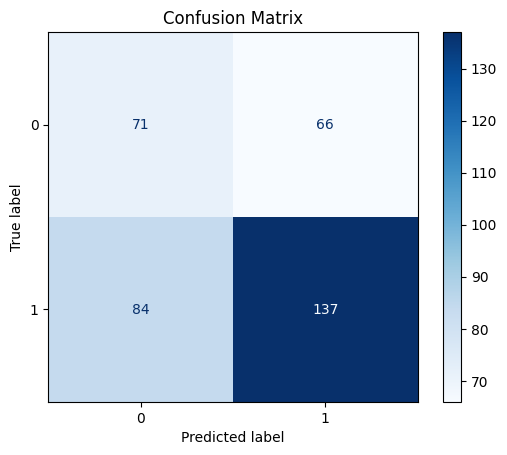

In [130]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred)

In [131]:
y_test.value_counts()

rain_in_7_days
1    221
0    137
Name: count, dtype: int64

In [132]:
# Predicted probabilities for positive class
y_probs = final_model.predict_proba(X_test)[:, 1]

# Candidate thresholds
thresholds = np.linspace(0, 1, 101)

# Compute weighted F1 for each threshold
weighted_f1_scores = [
    f1_score(y_test, (y_probs >= t).astype(int), average='weighted')
    for t in thresholds
]

# Find threshold that maximizes weighted F1
best_idx = np.argmax(weighted_f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for weighted F1:", best_threshold)
print("Weighted F1 at best threshold:", weighted_f1_scores[best_idx])

y_pred_wf1 = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold for weighted F1: 0.49
Weighted F1 at best threshold: 0.6023200113893629



Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49       137
           1       0.68      0.66      0.67       221

    accuracy                           0.60       358
   macro avg       0.58      0.58      0.58       358
weighted avg       0.60      0.60      0.60       358



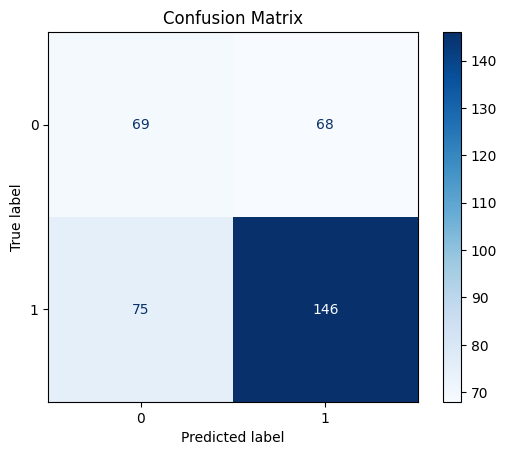

In [133]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_wf1)

In [134]:

y_probs = final_model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 101)

f1_scores = [f1_score(y_test, (y_probs >= t).astype(int)) for t in thresholds]
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold for F1:", best_threshold)
y_pred_f1 = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold for F1: 0.31



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.01       137
           1       0.62      1.00      0.76       221

    accuracy                           0.62       358
   macro avg       0.81      0.50      0.39       358
weighted avg       0.76      0.62      0.48       358



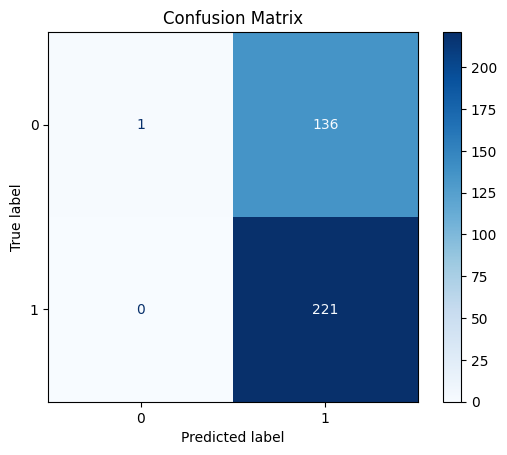

In [135]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_f1)

In [136]:
from sklearn.metrics import precision_recall_curve, auc

# Predicted probabilities
y_probs = final_model.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1 at each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid division by 0

# Pick threshold with max F1
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("Best threshold based on PR curve (max F1):", best_threshold)

# Optional: compute PR AUC
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

y_pred_pr = (final_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

Best threshold based on PR curve (max F1): 0.33716565
PR AUC: 0.6959361307295122



Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.02      0.04       137
           1       0.62      1.00      0.77       221

    accuracy                           0.62       358
   macro avg       0.69      0.51      0.40       358
weighted avg       0.67      0.62      0.49       358



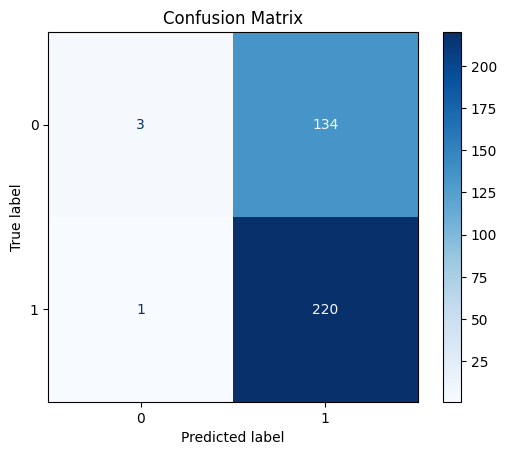

In [137]:
from my_krml_25552249.models.performance import report_and_conf_matrix, plot_roc
report_and_conf_matrix(y_test, y_pred_pr)

<Figure size 1000x600 with 0 Axes>

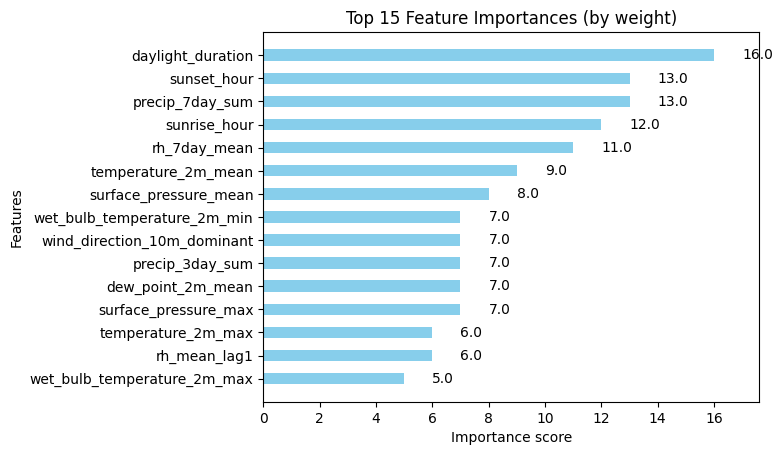

In [138]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming final_model is your trained XGBClassifier
# Plot feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(final_model, importance_type='weight', max_num_features=15, height=0.5, color='skyblue')
plt.title("Top 15 Feature Importances (by weight)")
plt.grid(False)
plt.show()

In [139]:
weighted_f1 = f1_score(y_test, y_pred, average='weighted')
print("Weighted F1:", weighted_f1)

Weighted F1: 0.5850260486231339


#### Compare to baseline

In [140]:
# Find the most common class in training set
majority_class = y_data.mode()[0]
print("Majority class:", majority_class)

# Baseline predictions for test set
y_baseline = [majority_class] * len(y_test)

# F1 score
baseline_f1 = f1_score(y_test, y_baseline)
baseline_wf1 = f1_score(y_test, y_baseline, average='weighted')
print("Baseline F1 score:", baseline_f1)
print("Baseline weighted F1 score", baseline_wf1)

# ROC AUC
# For roc_auc_score, need predicted probabilities for the positive class
# Here we assign 1.0 if majority class is 1, else 0.0
if majority_class == 1:
    y_probs_baseline = [1] * len(y_test)
else:
    y_probs_baseline = [0] * len(y_test)

baseline_auc = roc_auc_score(y_test, y_probs_baseline)
print("Baseline ROC AUC:", baseline_auc)

Majority class: 1
Baseline F1 score: 0.7633851468048359
Baseline weighted F1 score 0.47125172470354393
Baseline ROC AUC: 0.5


In [ ]:
# <Student to fill this section>
model_performance_explanations = """
Provide some explanations on model performance
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [ ]:
# <Student to fill this section>

In [ ]:
# <Student to fill this section>
business_impacts_explanations = """
Interpret the results of the experiments related to the business objective set earlier. Estimate the impacts of the incorrect results for the business (some results may have more impact compared to others)
"""

In [ ]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [ ]:
# <Student to fill this section>
experiment_outcome = "" # Either 'Hypothesis Confirmed', 'Hypothesis Partially Confirmed' or 'Hypothesis Rejected'

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [ ]:
# <Student to fill this section>
experiment_results_explanations = """
Reflect on the outcome of the experiment and list the new insights you gained from it. Provide rationale for pursuing more experimentation with the current approach or call out if you think it is a dead end.
Given the results achieved and the overall objective of the project, list the potential next steps and experiments. For each of them assess the expected uplift or gains and rank them accordingly. If the experiment achieved the required outcome for the business, recommend the steps to deploy this solution into production.
"""

In [ ]:
# Do not modify this code
print_tile(size="h2", key='experiment_results_explanations', value=experiment_results_explanations)